In [3]:
import numpy as np
import pandas as pd

In [24]:
atac_path = 'Tab_delimited_text\Hackathon2024.ATAC.txt.gz'
rna_path = 'Tab_delimited_text\Hackathon2024.RNA.txt.gz'
meta_path = 'Tab_delimited_text\Hackathon2024.Meta.txt.gz'
training_path = 'Tab_delimited_text\Hackathon2024.Training.Set.Peak2Gene.Pairs.txt.gz'
testing_path = 'Tab_delimited_text\Hackathon2024.Testing.Set.Peak2Gene.Pairs.txt.gz'

In [14]:
df = pd.read_csv(rna_path, sep='\t', compression='gzip')
df = df.set_index(keys='gene', drop=True)
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 36601 entries, MIR1302-2HG to AC007325.2
Columns: 2999 entries, AAACCAACACAATGCC.1 to TTTGTTGGTCAGGAAG.1
dtypes: int64(2999)
memory usage: 837.7+ MB
None


,AAACCAACACAATGCC.1,AAACCAACAGGAACTG.1,AAACCAACATAATCCG.1,AAACCAACATTGTGCA.1,AAACCGCGTACTTCAC.1,AAACCGGCATAATCAC.1,AAACGCGCAGCAAGAT.1,AAACGGATCCCATAGG.1,AAAGCAAGTGCTAGCG.1,AAAGCCCGTCCTTTAA.1,...,TTTGTCCCAGTAGGAT.1,TTTGTCTAGCTATTAG.1,TTTGTCTAGGACCTGC.1,TTTGTGAAGCGATACT.1,TTTGTGAAGGAACGGT.1,TTTGTGGCAGCAACCT.1,TTTGTGTTCATTGACA.1,TTTGTGTTCGTCAAGT.1,TTTGTGTTCTCCATAT.1,TTTGTTGGTCAGGAAG.1
gene,,,,,,,,,,,,,,,,,,,,,
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
def read_df(df_path,keys):
    tdf = pd.read_csv(df_path, sep='\t', compression='gzip')
    tdf = tdf.set_index(keys, drop=True)
    return tdf

rna_df = read_df(rna_path,'gene')
atac_df = read_df(atac_path, 'peak')

In [25]:
training_df = pd.read_csv(training_path, sep='\t')
testing_df = pd.read_csv(testing_path, sep='\t')

# Linear Regression

Every 'cell' is an observation of the peak and rna in that cell. 

For every pair of peak and gene, an ordinary least square regression checks for the statistical significance of their relationship. 

A statistical significance level 'alpha' is chosen whereby all p-values below this means that such a pair of peak and gene is valid.

This method is less prone to overfitting if the statistical significance level is chosen based on statistical theory.

In [26]:
# set statistical significant level
alpha = 0.005

In [27]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# predict on training set

pvalues = []

for i in range(len(training_df)):
    cell = training_df.iloc[i]
    X = atac_df.loc[cell['peak']].to_frame()
    y = rna_df.loc[cell['gene']]

    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    pvalues.append(est2.pvalues[1])

# get p-values
training_df['pvalues'] = pvalues

# produce prediction -- set alpha = 0.01
training_df['y'] = training_df['pvalues'] < alpha

Text(0.5, 1.0, 'P-Values, training set: first 150 is TRUE')

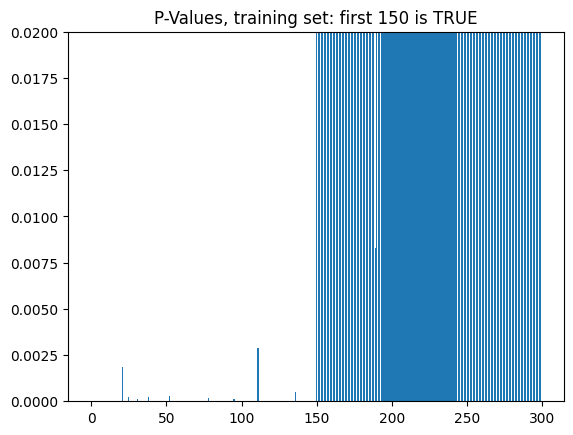

In [28]:
from matplotlib import pyplot as plt

plt.ylim(0, 0.02)
plt.bar(range(0,300), training_df['pvalues'])
plt.title('P-Values, training set: first 150 is TRUE')

In [29]:
# compare between predicted and true classification
training_df['check'] = training_df['y'] ^ training_df['Peak2Gene']

# check to see how many wrong classification
sum(training_df['check'])

0

In [30]:
# predict on testing set
pvalues = []

for i in range(len(testing_df)):
    cell = testing_df.iloc[i]
    X = atac_df.loc[cell['peak']].to_frame()
    y = rna_df.loc[cell['gene']]

    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    pvalues.append(est2.pvalues[1])

testing_df['pvalues'] = pvalues
testing_df['Peak2Gene'] = testing_df['pvalues'] < alpha

testing_df = testing_df.drop('pvalues', axis=1)
testing_df

,peak,gene,Pair,Peak2Gene
0,chr1-1245493-1248050,SDF4,chr1-1245493-1248050_SDF4,False
1,chr1-1330394-1334148,MRPL20,chr1-1330394-1334148_MRPL20,False
2,chr1-2145904-2147150,FAAP20,chr1-2145904-2147150_FAAP20,False
3,chr1-9713011-9736481,PIK3CD,chr1-9713011-9736481_PIK3CD,True
4,chr1-21287896-21301043,ECE1,chr1-21287896-21301043_ECE1,True
...,...,...,...,...
295,chr22-39513720-39514799,ATF4,chr22-39513720-39514799_ATF4,False
296,chr22-39898750-39899616,GRAP2,chr22-39898750-39899616_GRAP2,False
297,chr22-40863752-40864675,ST13,chr22-40863752-40864675_ST13,False
298,chr22-44204897-44207872,PARVG,chr22-44204897-44207872_PARVG,False


In [32]:
testing_df.to_csv('prediction/prediction.csv', index=False)

# Linh



In [31]:
df.iloc[14].value_counts()

LINC01409
0    2829
1     143
2      24
3       2
5       1
Name: count, dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108344 entries, chr1-10109-10357 to chrY-56836663-56837005
Columns: 2999 entries, AAACCAACACAATGCC.1 to TTTGTTGGTCAGGAAG.1
dtypes: int64(2999)
memory usage: 2.4+ GB


In [5]:
# Get the first row
first_row = df.iloc[0]

# Filter the columns where the value is 1
first_row[first_row == 1]


AGTAGCTTCGGGATTT.1    1
ATGAATGCATTGTCAG.1    1
GCCATGATCCAGGGAG.1    1
GTGCAAGCAAGGTGCA.1    1
TATTCGTTCCGCCTCA.1    1
TTTAGCTTCCGCAACA.1    1
TTTGTGTTCATTGACA.1    1
Name: 0, dtype: object

### PCA

#### 1. Standardization
Standardize the data to ensure that all features contribute equally to the PCA.

#### 2. Performing PCA
Apply PCA to the standardized data to reduce dimensionality and capture the most important features.

#### 4. Variance Explained
After applying PCA, it's useful to check how much variance is explained by the principal components:

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
df_atac = pd.read_csv(atac_path, sep='\t', compression='gzip').set_index(keys='peak', drop=True)
# Assuming df_atac is your ATAC dataframe
scaler = StandardScaler()
scaled_atac = scaler.fit_transform(df_atac)

In [37]:
df_atac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108344 entries, chr1-10109-10357 to chrY-56836663-56837005
Columns: 2999 entries, AAACCAACACAATGCC.1 to TTTGTTGGTCAGGAAG.1
dtypes: int64(2999)
memory usage: 2.4+ GB


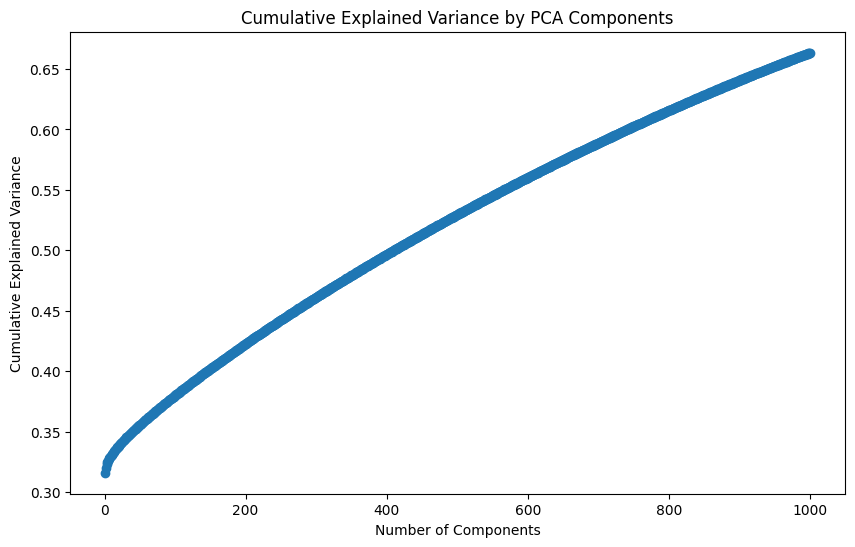

In [38]:
# Initialize PCA
pca = PCA(n_components=1000)  # Choose the number of components to keep
atac_pca = pca.fit_transform(scaled_atac)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Plotting the explained variance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

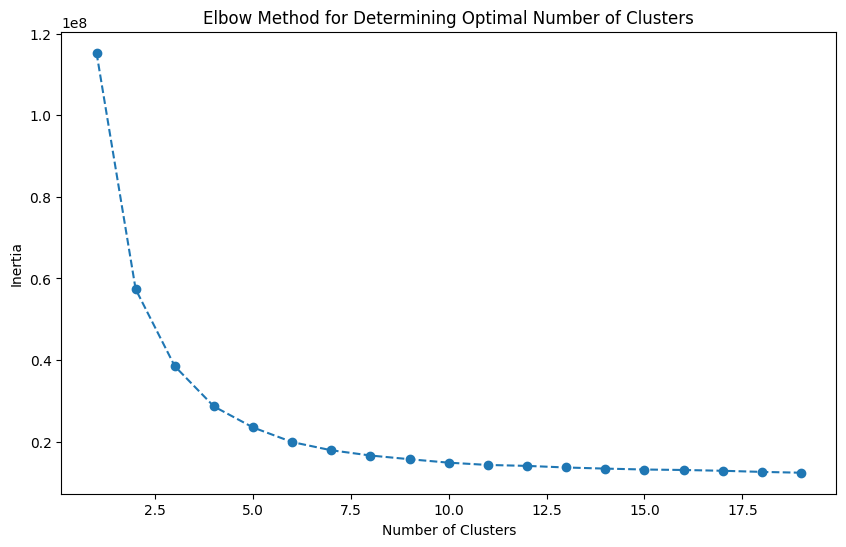

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow method
inertia = []
range_n_clusters = range(1, 20)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(atac_pca)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.show()


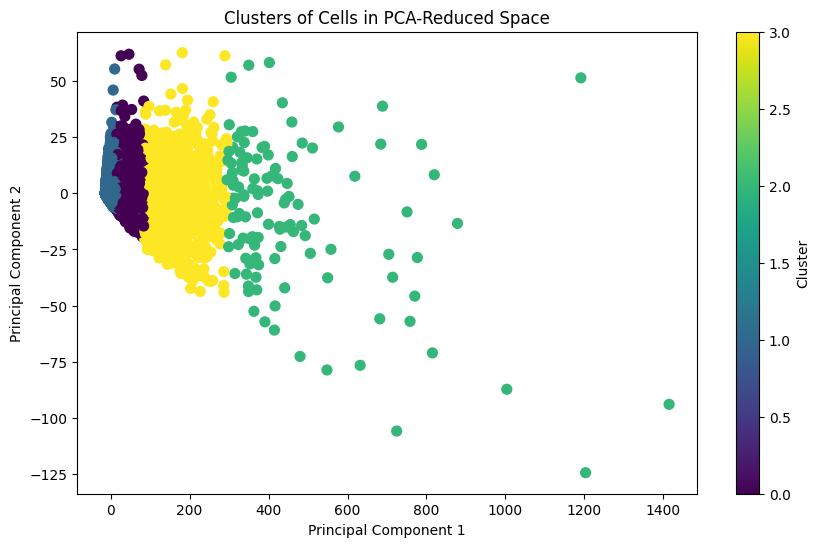

In [26]:
# Applying K-means with the chosen number of clusters (e.g., k=6)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(atac_pca)

# Adding the cluster labels to the PCA-transformed data
import pandas as pd

pca_df = pd.DataFrame(atac_pca, columns=[f'PC{i+1}' for i in range(atac_pca.shape[1])])
pca_df['Cluster'] = clusters

plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters of Cells in PCA-Reduced Space')
plt.colorbar(label='Cluster')
plt.show()

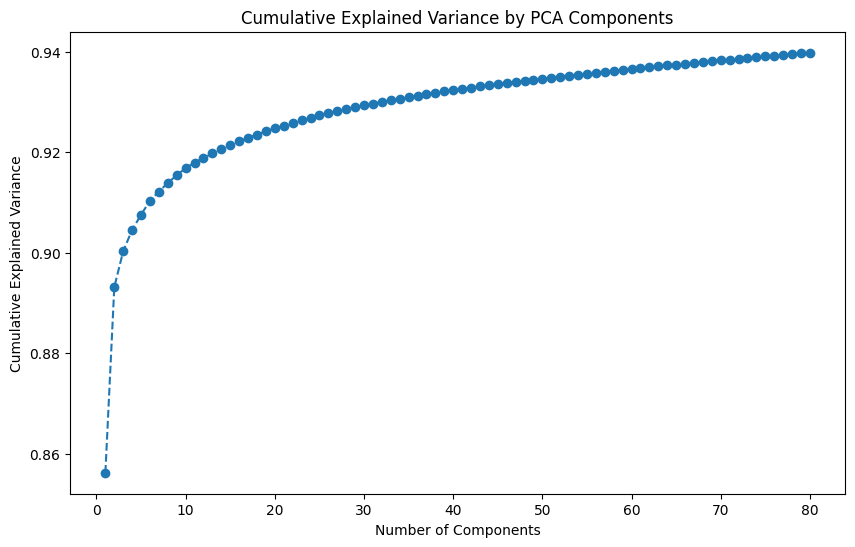

In [43]:
df_rna = pd.read_csv(rna_path, sep='\t', compression='gzip').set_index(keys='gene', drop=True)
# Assuming df_rna is your rna dataframe
scaler = StandardScaler()
scaled_rna = scaler.fit_transform(df_rna)

# Initialize PCA
pca = PCA(n_components=80)  # Choose the number of components to keep
rna_pca = pca.fit_transform(scaled_rna)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Plotting the explained variance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [42]:
df_rna.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36601 entries, MIR1302-2HG to AC007325.2
Columns: 2999 entries, AAACCAACACAATGCC.1 to TTTGTTGGTCAGGAAG.1
dtypes: int64(2999)
memory usage: 837.7+ MB


In [41]:
np.shape(rna_pca)

(36601, 50)